In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

In [3]:
Parser = Sbopen()

In [4]:
Parser.competition()
df,related,freeze,tactics = Parser.event(3749528)

In [5]:
#get team names
team1, team2 = df.team_name.unique()
#A dataframe of shots
shots = df.loc[df['type_name'] == 'Shot'].set_index('id')
passes = df.loc[df['type_name'] == 'Pass'].loc[df['sub_type_name'] != 'Throw-in'].set_index('id')

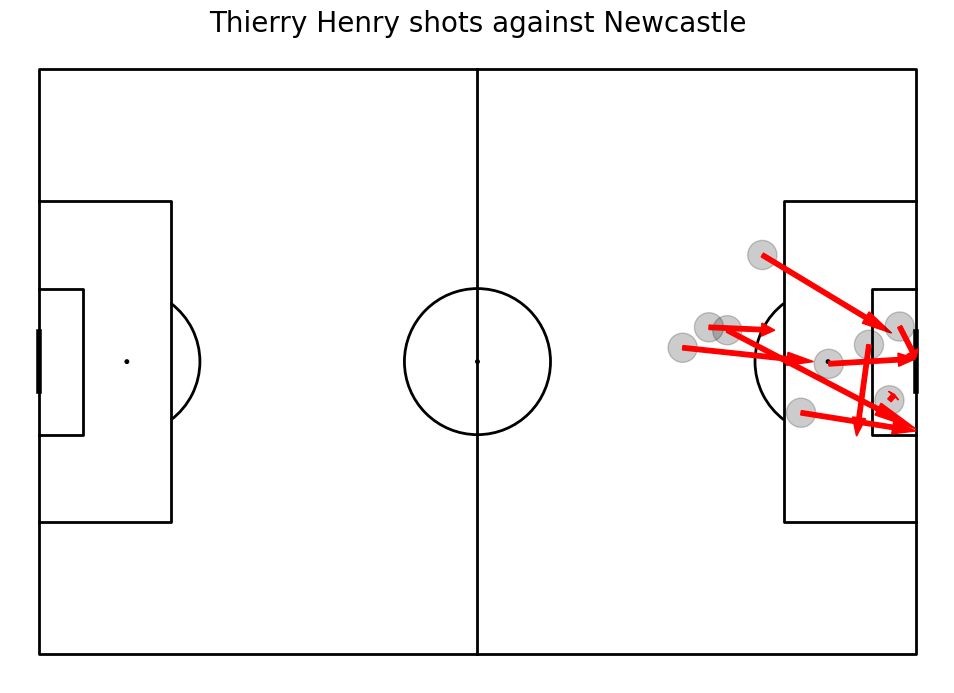

In [8]:
#drawing pitch

pitch = Pitch(line_color = "black")
fig, ax = pitch.draw(figsize = (10,7))

for i,theshot in shots.iterrows():
        #if shot made by Thierry Henry
                    
        if theshot['player_name']=='Thierry Henry':
            x=theshot['x']
            y=theshot['y']
            dx=theshot['end_x']-x
            dy=theshot['end_y']-y
            #plot circle
            passCircle=plt.Circle((x,y),2,color="black")
            passCircle.set_alpha(.2)
            ax.add_patch(passCircle)
            
            #plot arrow
            passArrow=plt.Arrow(x,y,dx,dy,width=3, color="red")
            ax.add_patch(passArrow)
                
ax.set_title("Thierry Henry shots against Newcastle", fontsize = 20)
fig.set_size_inches(10,7)


plt.show()

Text(0.5, 0.5, 'Arsenal passes against Newcastle')

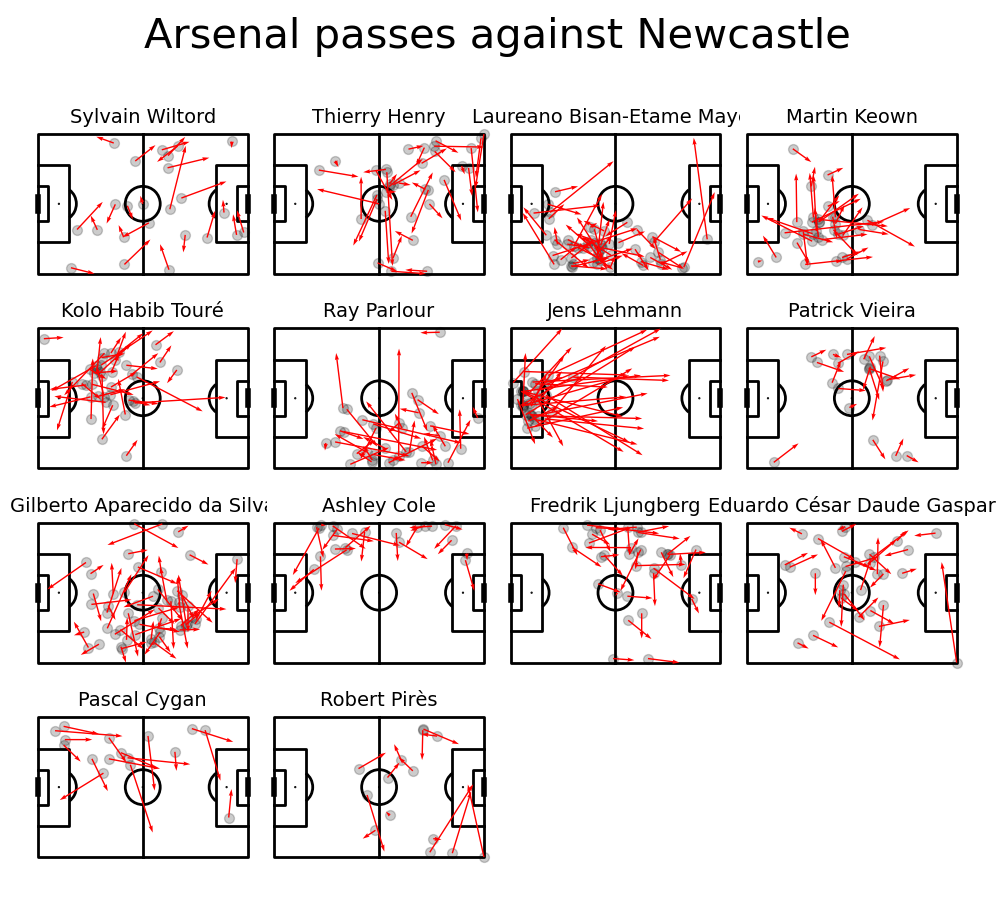

In [98]:
#prepare dataframe of passes by Arsenal that are not throw-ins

mask_arsenal = (df.type_name == 'Pass') & (df.team_name == "Arsenal") & (df.sub_type_name != "Throw-in")
df_passes=df.loc[mask_arsenal, ['x','y','end_x','end_y','player_name', 'pass_recipient_name']]

#get the list of players who make a pass
names = df_passes['player_name'].unique()

#draw 4x4 pitches

pitch = Pitch(line_color='black', pad_top=20)
fig,axs = pitch.grid(ncols=4, nrows=4,grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)

# for each player
for name, ax in zip(names,axs['pitch'].flat[:len(names)]):
    #put player name above plot
    ax.text(60,-10, name, 
           ha = 'center', va = 'center', fontsize=14)
    #take only passes by this player
    player_df=df_passes.loc[df_passes["player_name"] == name]
    #scatter
    pitch.scatter(player_df.x, player_df.y, alpha=0.2, s=50, color="black", ax = ax)
    #plot arrow
    pitch.arrows(player_df.x, player_df.y, player_df.end_x, player_df.end_y, color="red", ax=ax, width=1)
    
    #remove unneeded pitches
for ax in axs['pitch'][-1,16 - len(names):]:
        ax.remove()
        
#set entire title

axs['title'].text(0.5,0.5, 'Arsenal passes against Newcastle', ha = 'center', va = 'center', fontsize = 30)

In [127]:
#check for index of first sub
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"]=="Arsenal"].iloc[0]["index"]

#make df with successful passes by Arsenal until first sub
mask_arsenal=(df.type_name =='Pass') & (df.team_name == "Arsenal") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
df_pass=df.loc[mask_arsenal, ['x','y','end_x','end_y',"player_name","pass_recipient_name"]]
#only surnames
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x:str(x).split()[-1])

In [128]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx=df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx=df_pass.loc[df_pass["pass_recipient_name"]==name]["end_x"].to_numpy()
    passy=df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy=df_pass.loc[df_pass["pass_recipient_name"]==name]["end_y"].to_numpy()
    scatter_df.at[i,"player_name"]=name
    
    scatter_df.at[i,"x"]=np.mean(np.concatenate([passx,recx]))
    scatter_df.at[i,"y"]=np.mean(np.concatenate([passx,recy]))
    scatter_df.at[i,"no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

    
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [129]:
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns',inplace=True)

lines_df=lines_df[lines_df['pass_count']>2]

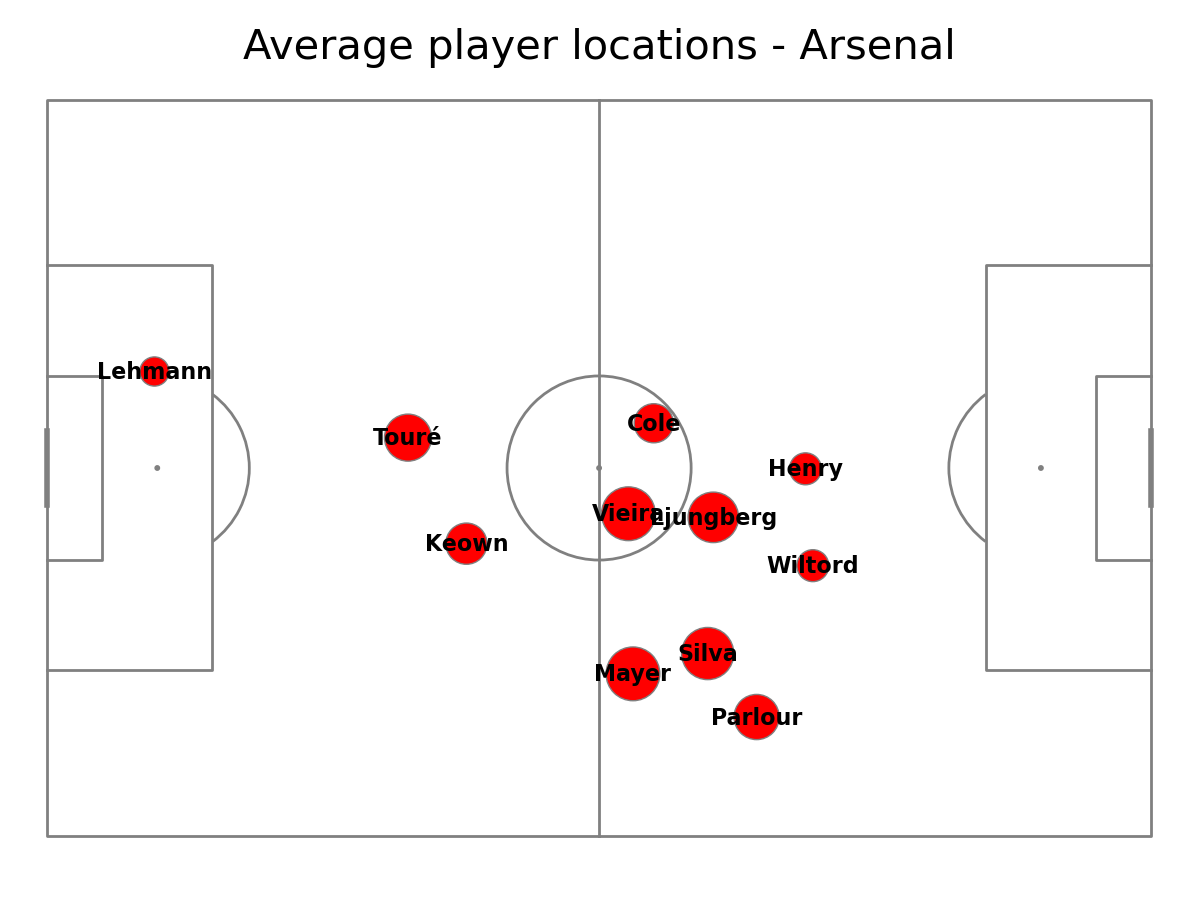

In [130]:
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, 
                    endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(scatter_df.x,scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey',linewidth=1,alpha=1,ax=ax["pitch"], zorder=3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name,xy=(row.x,row.y), c='black', va='center',ha='center',weight="bold", size=16, ax=ax["pitch"],zorder=4)

fig.suptitle("Average player locations - Arsenal", fontsize = 30)
plt.show()

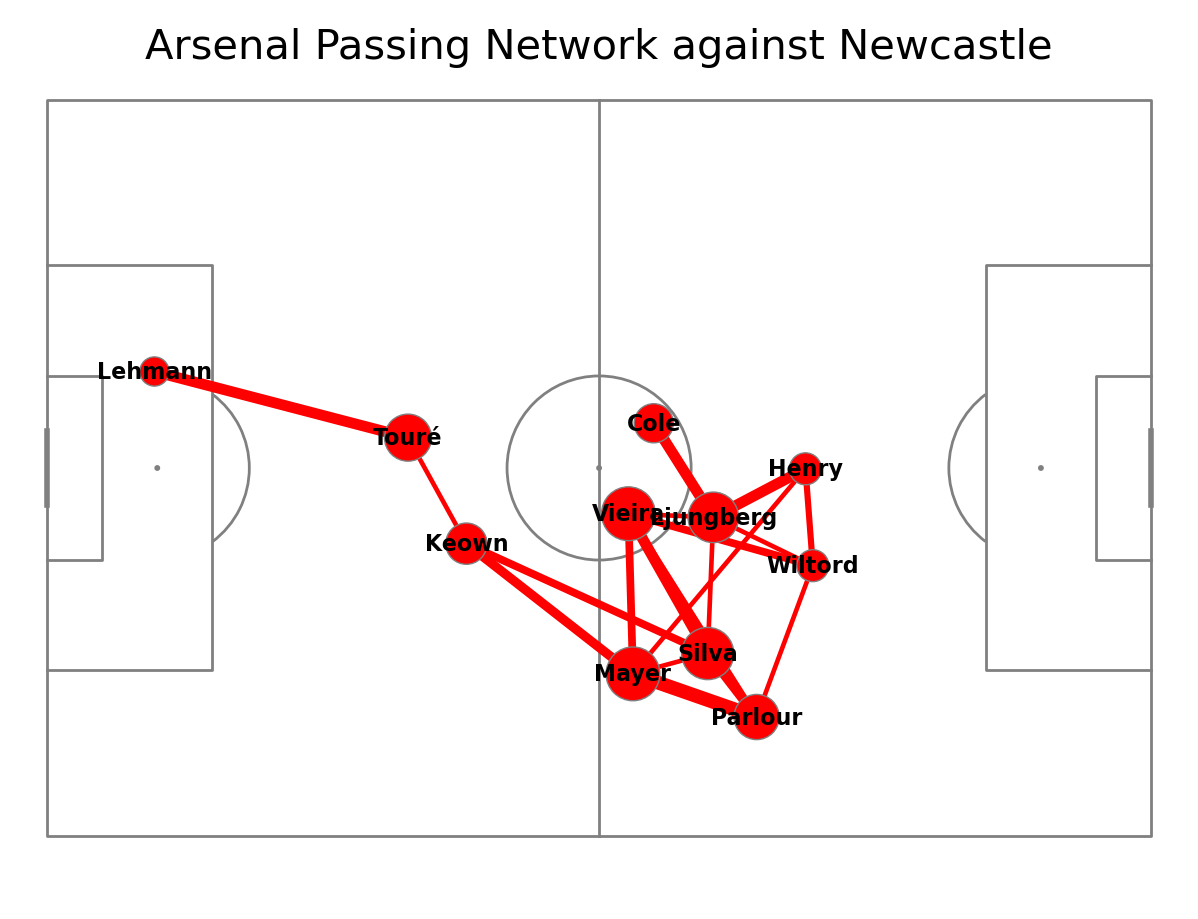

In [131]:
#plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle("Arsenal Passing Network against Newcastle", fontsize = 30)
plt.show()

In [136]:
parser = Sbopen()
df_match = parser.match(competition_id=2, season_id=44)
team = "Arsenal"
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
#calculate number of games
no_games = len(match_ids)
#declare an empty dataframe
danger_passes = pd.DataFrame()
for idx in match_ids:
    #open the event data from this game
    df = parser.event(idx)[0]
    for period in [1, 2]:
        #keep only accurate passes by England that were not set pieces in this period
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        #keep only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
        #keep only Shots by England in this period
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
        #keep only necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]
        #convert time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15
        #find starts of the window
        shot_start = shot_times - shot_window
        #condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        #convert to seconds
        pass_times = passes['minute']*60+passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period])

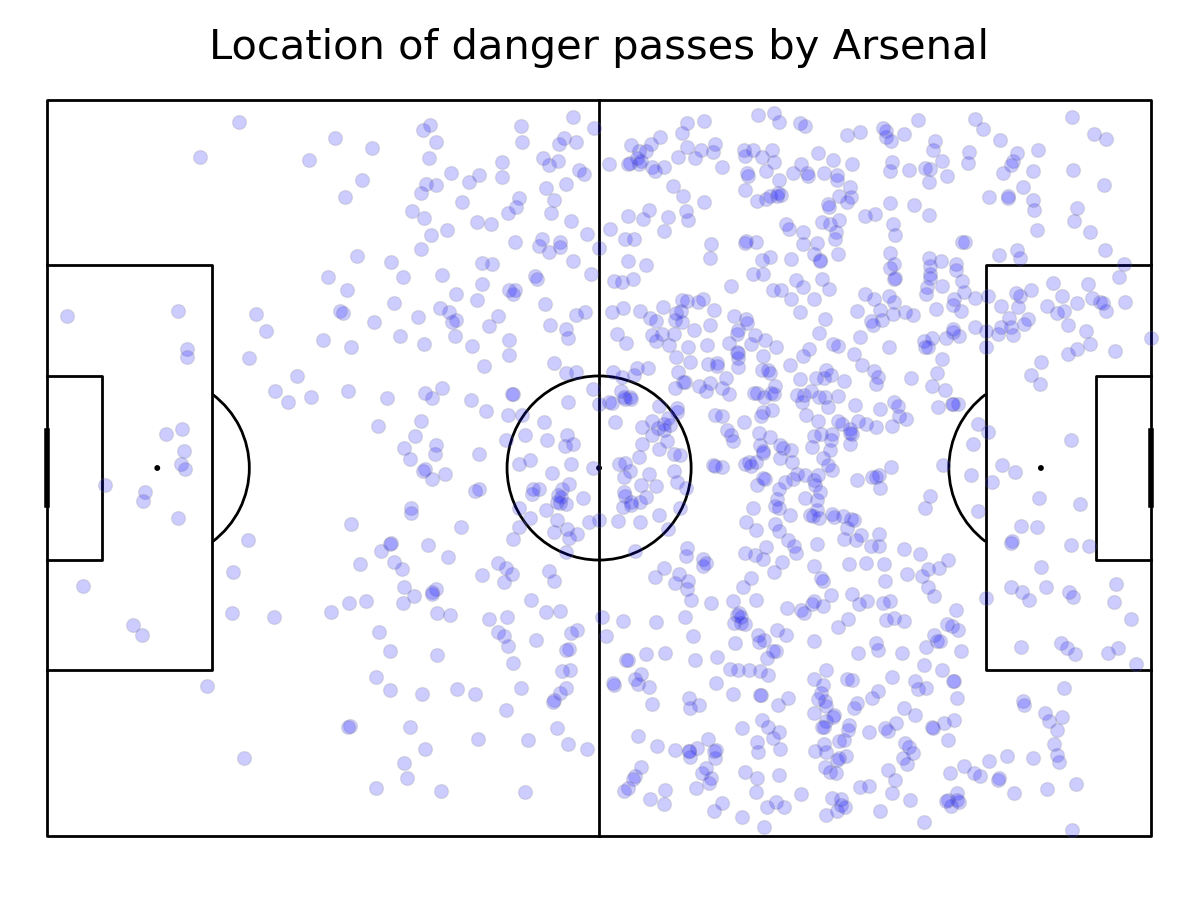

In [137]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
#uncomment it to plot arrows
#pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + team, fontsize = 30)
plt.show()

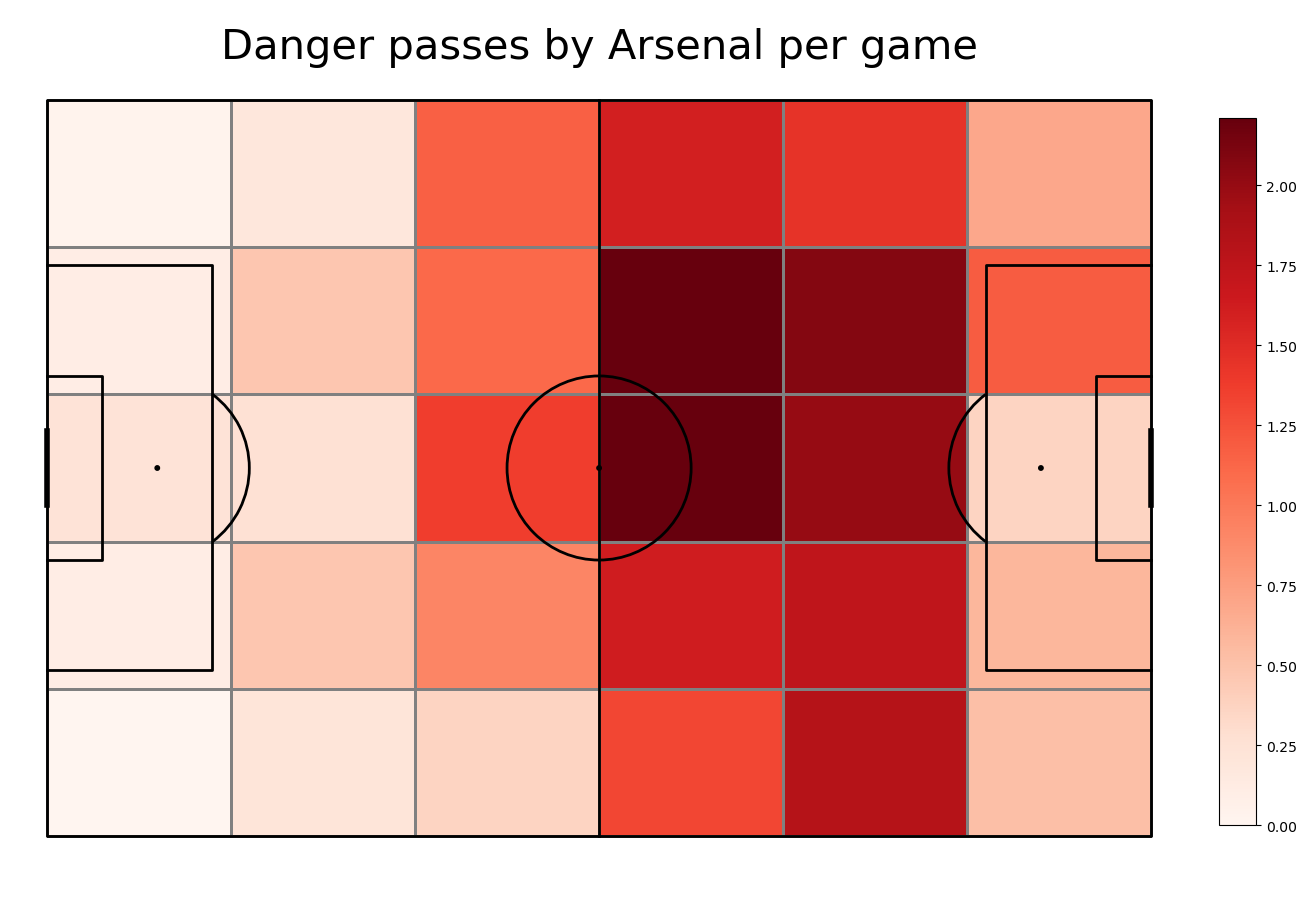

In [138]:
#plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()